### LASSO parameter range experiments

We want to see whether smaller models (i.e. models with fewer nonzero features) tend to generalize to new cancer types better than larger ones; this script compares/visualizes those results.

In [1]:
import os
import itertools as it

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import seaborn as sns

import pancancer_evaluation.config as cfg
import pancancer_evaluation.utilities.data_utilities as du
import pancancer_evaluation.utilities.analysis_utilities as au

%load_ext autoreload
%autoreload 2

In [2]:
base_results_dir = os.path.join(
    cfg.repo_root, '02_cancer_type_classification', 'results', 'lasso_range_lr_all_features'
)

training_dataset = 'all_other_cancers'
results_dir = os.path.join(base_results_dir, training_dataset)

plot_gene = 'PTEN'
metric = 'aupr'
nz_cutoff = 5.0

output_plots = False
output_plots_dir = cfg.cancer_type_lasso_range_dir

### Get coefficient information for each lasso penalty

In [3]:
nz_coefs_df = []

# get coefficient info for training dataset specified above
for coef_info in au.generate_nonzero_coefficients_lasso_range(results_dir, gene=plot_gene):
    (gene,
     cancer_type,
     seed,
     lasso_param,
     coefs_list) = coef_info
    for fold_no, coefs in enumerate(coefs_list):
        nz_coefs_df.append(
            [gene, cancer_type, lasso_param, seed, fold_no, len(coefs)]
        )
        
nz_coefs_df = pd.DataFrame(
    nz_coefs_df,
    columns=['gene', 'cancer_type', 'lasso_param', 'seed', 'fold', 'nz_coefs']
)
nz_coefs_df.lasso_param = nz_coefs_df.lasso_param.astype(float)
nz_coefs_df = nz_coefs_df[nz_coefs_df.gene == plot_gene].copy()
nz_coefs_df.head()

,gene,cancer_type,lasso_param,seed,fold,nz_coefs
0,PTEN,UCEC,750.000,42,0,14562
1,PTEN,UCEC,750.000,42,1,14881
2,PTEN,UCEC,750.000,42,2,14525
3,PTEN,UCEC,750.000,42,3,14553
4,PTEN,SKCM,0.001,1,0,0


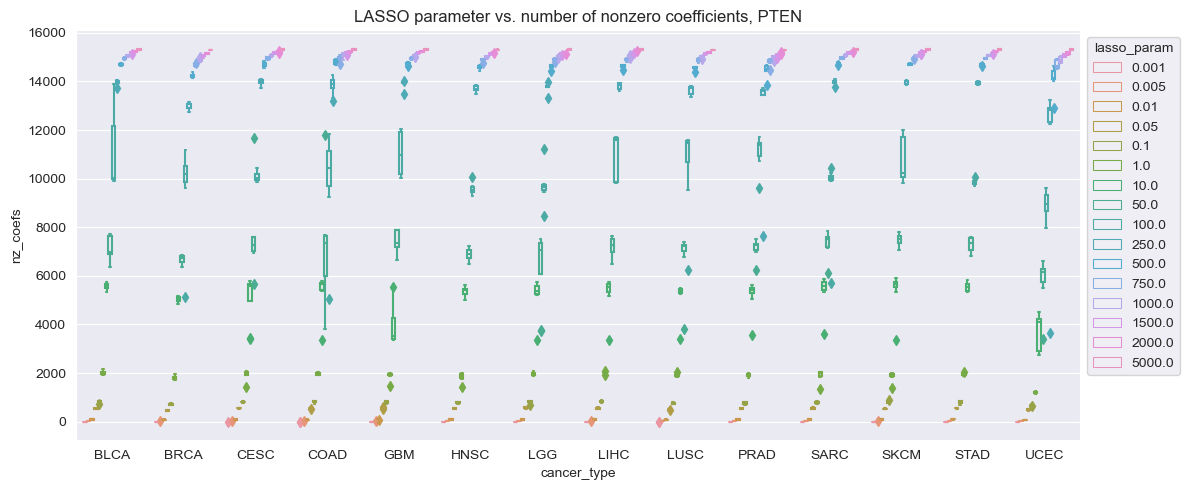

In [4]:
sns.set({'figure.figsize': (12, 5)})

sns.boxplot(
    data=nz_coefs_df.sort_values(by=['cancer_type', 'lasso_param']),
    x='cancer_type', y='nz_coefs', hue='lasso_param'
)

# color the boxplot lines/edges rather than the box fill
# this makes it easier to discern colors at the extremes; i.e. very many or few nonzero coefs
# https://stackoverflow.com/a/72333641
ax = plt.gca()
box_patches = [patch for patch in ax.patches if type(patch) == matplotlib.patches.PathPatch]
num_patches = len(box_patches)
lines_per_boxplot = len(ax.lines) // num_patches
for i, patch in enumerate(box_patches):
    # set the linecolor on the patch to the facecolor, and set the facecolor to None
    col = patch.get_facecolor()
    patch.set_edgecolor(col)
    patch.set_facecolor('None')

    # each box has associated Line2D objects (to make the whiskers, fliers, etc.)
    # loop over them here, and use the same color as above
    for line in ax.lines[i * lines_per_boxplot: (i + 1) * lines_per_boxplot]:
        line.set_color(col)
        line.set_mfc(col)  # facecolor of fliers
        line.set_mec(col)  # edgecolor of fliers

# also fix the legend to color the edges rather than fill
for legpatch in ax.legend_.get_patches():
    col = legpatch.get_facecolor()
    legpatch.set_edgecolor(col)
    legpatch.set_facecolor('None')

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title(f'LASSO parameter vs. number of nonzero coefficients, {plot_gene}')
plt.tight_layout()

### Get performance information for each lasso penalty

In [5]:
perf_df = au.load_prediction_results_lasso_range(results_dir,
                                                 training_dataset,
                                                 gene=plot_gene)
perf_df = perf_df[perf_df.gene == plot_gene].copy()
perf_df.head()

,auroc,aupr,gene,holdout_cancer_type,signal,seed,data_type,fold,experiment,lasso_param
0,1.00000,1.000000,PTEN,SARC,signal,42,train,0,all_other_cancers,1500.0
1,0.46296,0.065267,PTEN,SARC,signal,42,test,0,all_other_cancers,1500.0
2,0.84967,0.500280,PTEN,SARC,signal,42,cv,0,all_other_cancers,1500.0
3,1.00000,1.000000,PTEN,SARC,signal,42,train,1,all_other_cancers,1500.0
4,0.72549,0.354840,PTEN,SARC,signal,42,test,1,all_other_cancers,1500.0


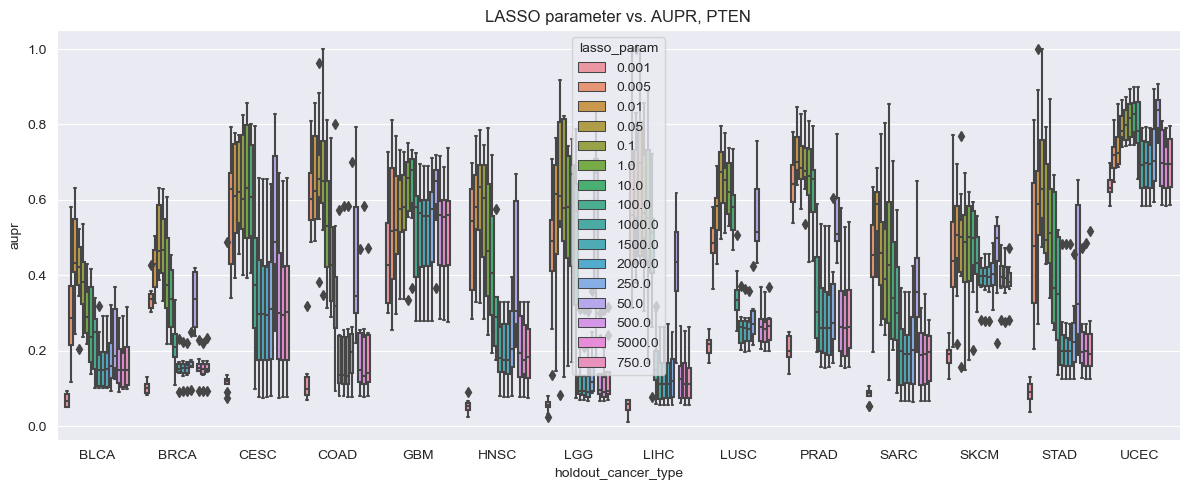

In [6]:
sns.set({'figure.figsize': (12, 5)})

sns.boxplot(
    data=(
        perf_df[(perf_df.signal == 'signal') &
                (perf_df.data_type == 'test')]
          .sort_values(by=['holdout_cancer_type', 'lasso_param'])
    ), x='holdout_cancer_type', y=metric, hue='lasso_param'
)
plt.title(f'LASSO parameter vs. {metric.upper()}, {plot_gene}')
plt.tight_layout()

if output_plots:
    output_plots_dir.mkdir(exist_ok=True)
    plt.savefig(output_plots_dir / f'{plot_gene}_lasso_boxes.png',
                dpi=200, bbox_inches='tight')

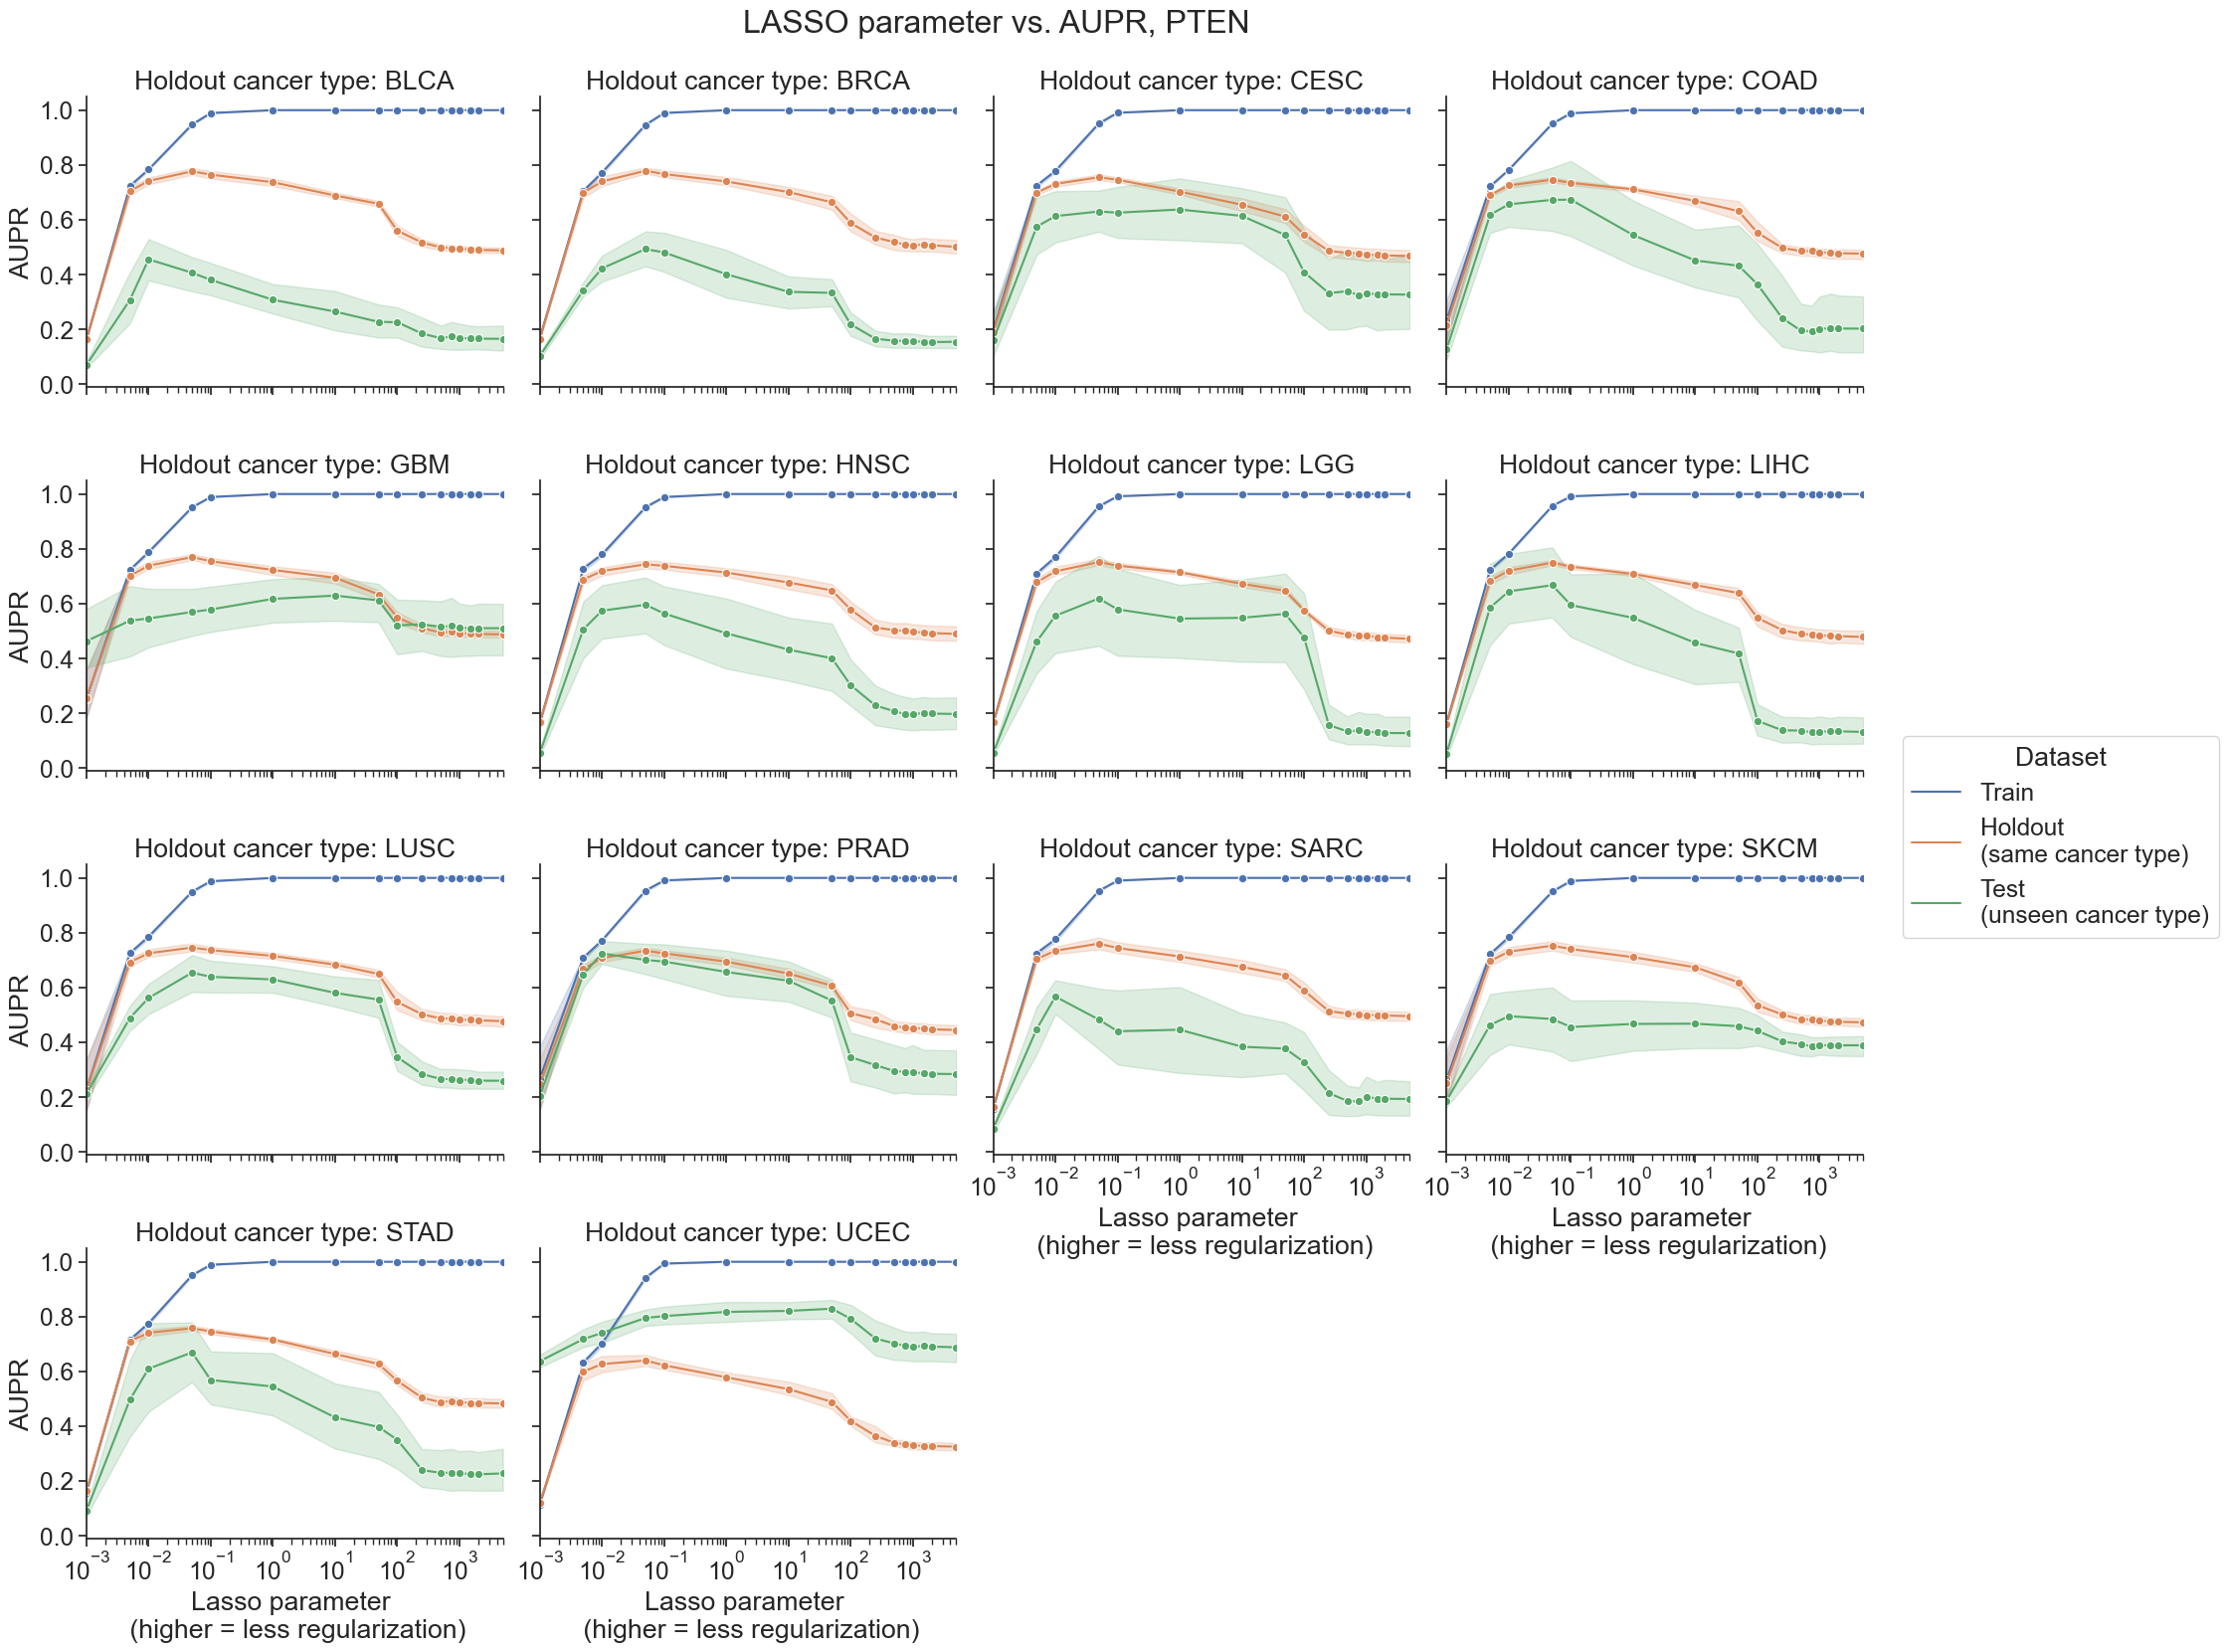

In [7]:
# try with a float-valued x-axis
# this is probably more "correct" than treating each lasso parameter as a
# category (above plot); here the spaces between parameters reflect their
# actual real-valued distance in log-space
sns.set_style('ticks')

plot_df = (
    perf_df[(perf_df.signal == 'signal')]
      .sort_values(by=['holdout_cancer_type', 'lasso_param'])
      .reset_index(drop=True)
)
plot_df.lasso_param = plot_df.lasso_param.astype(float)

with sns.plotting_context('notebook', font_scale=1.6):
    g = sns.relplot(
        data=plot_df,
        x='lasso_param', y=metric, hue='data_type',
        hue_order=['train', 'cv', 'test'],
        marker='o',
        kind='line', col='holdout_cancer_type',
        col_wrap=4, height=4, aspect=1.2
    )
    g.set(xscale='log', xlim=(min(plot_df.lasso_param), max(plot_df.lasso_param)))
    g.set_titles('Holdout cancer type: {col_name}')
    g.set_xlabels('LASSO parameter \n (higher = less regularization)')
    g.set_ylabels(f'{metric.upper()}')
    plt.suptitle(f'LASSO parameter vs. {metric.upper()}, {plot_gene}', y=1.02)
    sns.move_legend(g, "center", bbox_to_anchor=[1.02, 0.5], frameon=True)
    g._legend.set_title('Dataset')
    new_labels = ['Train', 'Holdout \n(same cancer type)', 'Test \n(unseen cancer type)']
    for t, l in zip(g._legend.texts, new_labels):
        t.set_text(l)

if output_plots:
    plt.savefig(output_plots_dir / f'{plot_gene}_lasso_facets.png',
                dpi=200, bbox_inches='tight')

### Visualize "best" LASSO parameters for the given gene

We want to use two different strategies to pick the "best" LASSO parameter:

1. Choose the top 25% of LASSO parameters based on validation set AUPR, then take the smallest model (least nonzero coefficients) in that set. This is the "parsimonious" approach that assumes that smaller models will generalize better.
2. Choose the top LASSO parameter based solely on validation set AUPR, without considering model size. This is the "non-parsimonious" approach.

We'll plot the results of both strategies (which sometimes select the same parameter, but usually they're different) for the given gene below.

In [8]:
def get_top_and_smallest_lasso_params(cancer_type):
    top_df = (
        perf_df[(perf_df.data_type == 'cv') &
                (perf_df.signal == 'signal') &
                (perf_df.holdout_cancer_type == cancer_type)]
          .groupby(['lasso_param'])
          .agg(np.mean)
          .drop(columns=['seed', 'fold'])
          .rename(columns={'auroc': 'mean_auroc', 'aupr': 'mean_aupr'})
          .sort_values(by='mean_aupr', ascending=False)
    )
    top_df.index = top_df.index.astype(float)
    top_df['aupr_rank'] = top_df.mean_aupr.rank(ascending=False)
    top_5_lasso = top_df.loc[top_df.aupr_rank <= 5, :].index
    
    # get parameter with best validation performance
    top_lasso_param = top_5_lasso[0]

    # get parameter in top 5 validation performance with least nonzero coefficients
    smallest_lasso_param = (
        nz_coefs_df[(nz_coefs_df.cancer_type == cancer_type) &
                    (nz_coefs_df.lasso_param.isin(top_5_lasso))]
          .groupby(['lasso_param'])
          .agg(np.mean)
          .drop(columns=['seed', 'fold'])
          .sort_values(by='nz_coefs', ascending=True)
    ).index[0]
    
    compare_df = top_df.loc[
        [smallest_lasso_param, top_lasso_param], :
    ]
    compare_df['cancer_type'] = cancer_type
    compare_df['desc'] = ['smallest', 'best']
    return compare_df

In [9]:
get_top_and_smallest_lasso_params(perf_df.holdout_cancer_type.unique()[0])

,mean_auroc,mean_aupr,aupr_rank,cancer_type,desc
lasso_param,,,,,
0.005,0.897710,0.703816,5.0,SARC,smallest
0.050,0.926581,0.759990,1.0,SARC,best


In [10]:
compare_all_df = []
for cancer_type in perf_df.holdout_cancer_type.unique():
    compare_all_df.append(
        get_top_and_smallest_lasso_params(cancer_type)
    )
    
compare_all_df = pd.concat(compare_all_df)
compare_all_df.head(5)

,mean_auroc,mean_aupr,aupr_rank,cancer_type,desc
lasso_param,,,,,
0.005,0.897710,0.703816,5.0,SARC,smallest
0.050,0.926581,0.759990,1.0,SARC,best
0.005,0.889543,0.698501,5.0,CESC,smallest
0.050,0.921895,0.754699,1.0,CESC,best
0.005,0.880439,0.677459,5.0,LGG,smallest


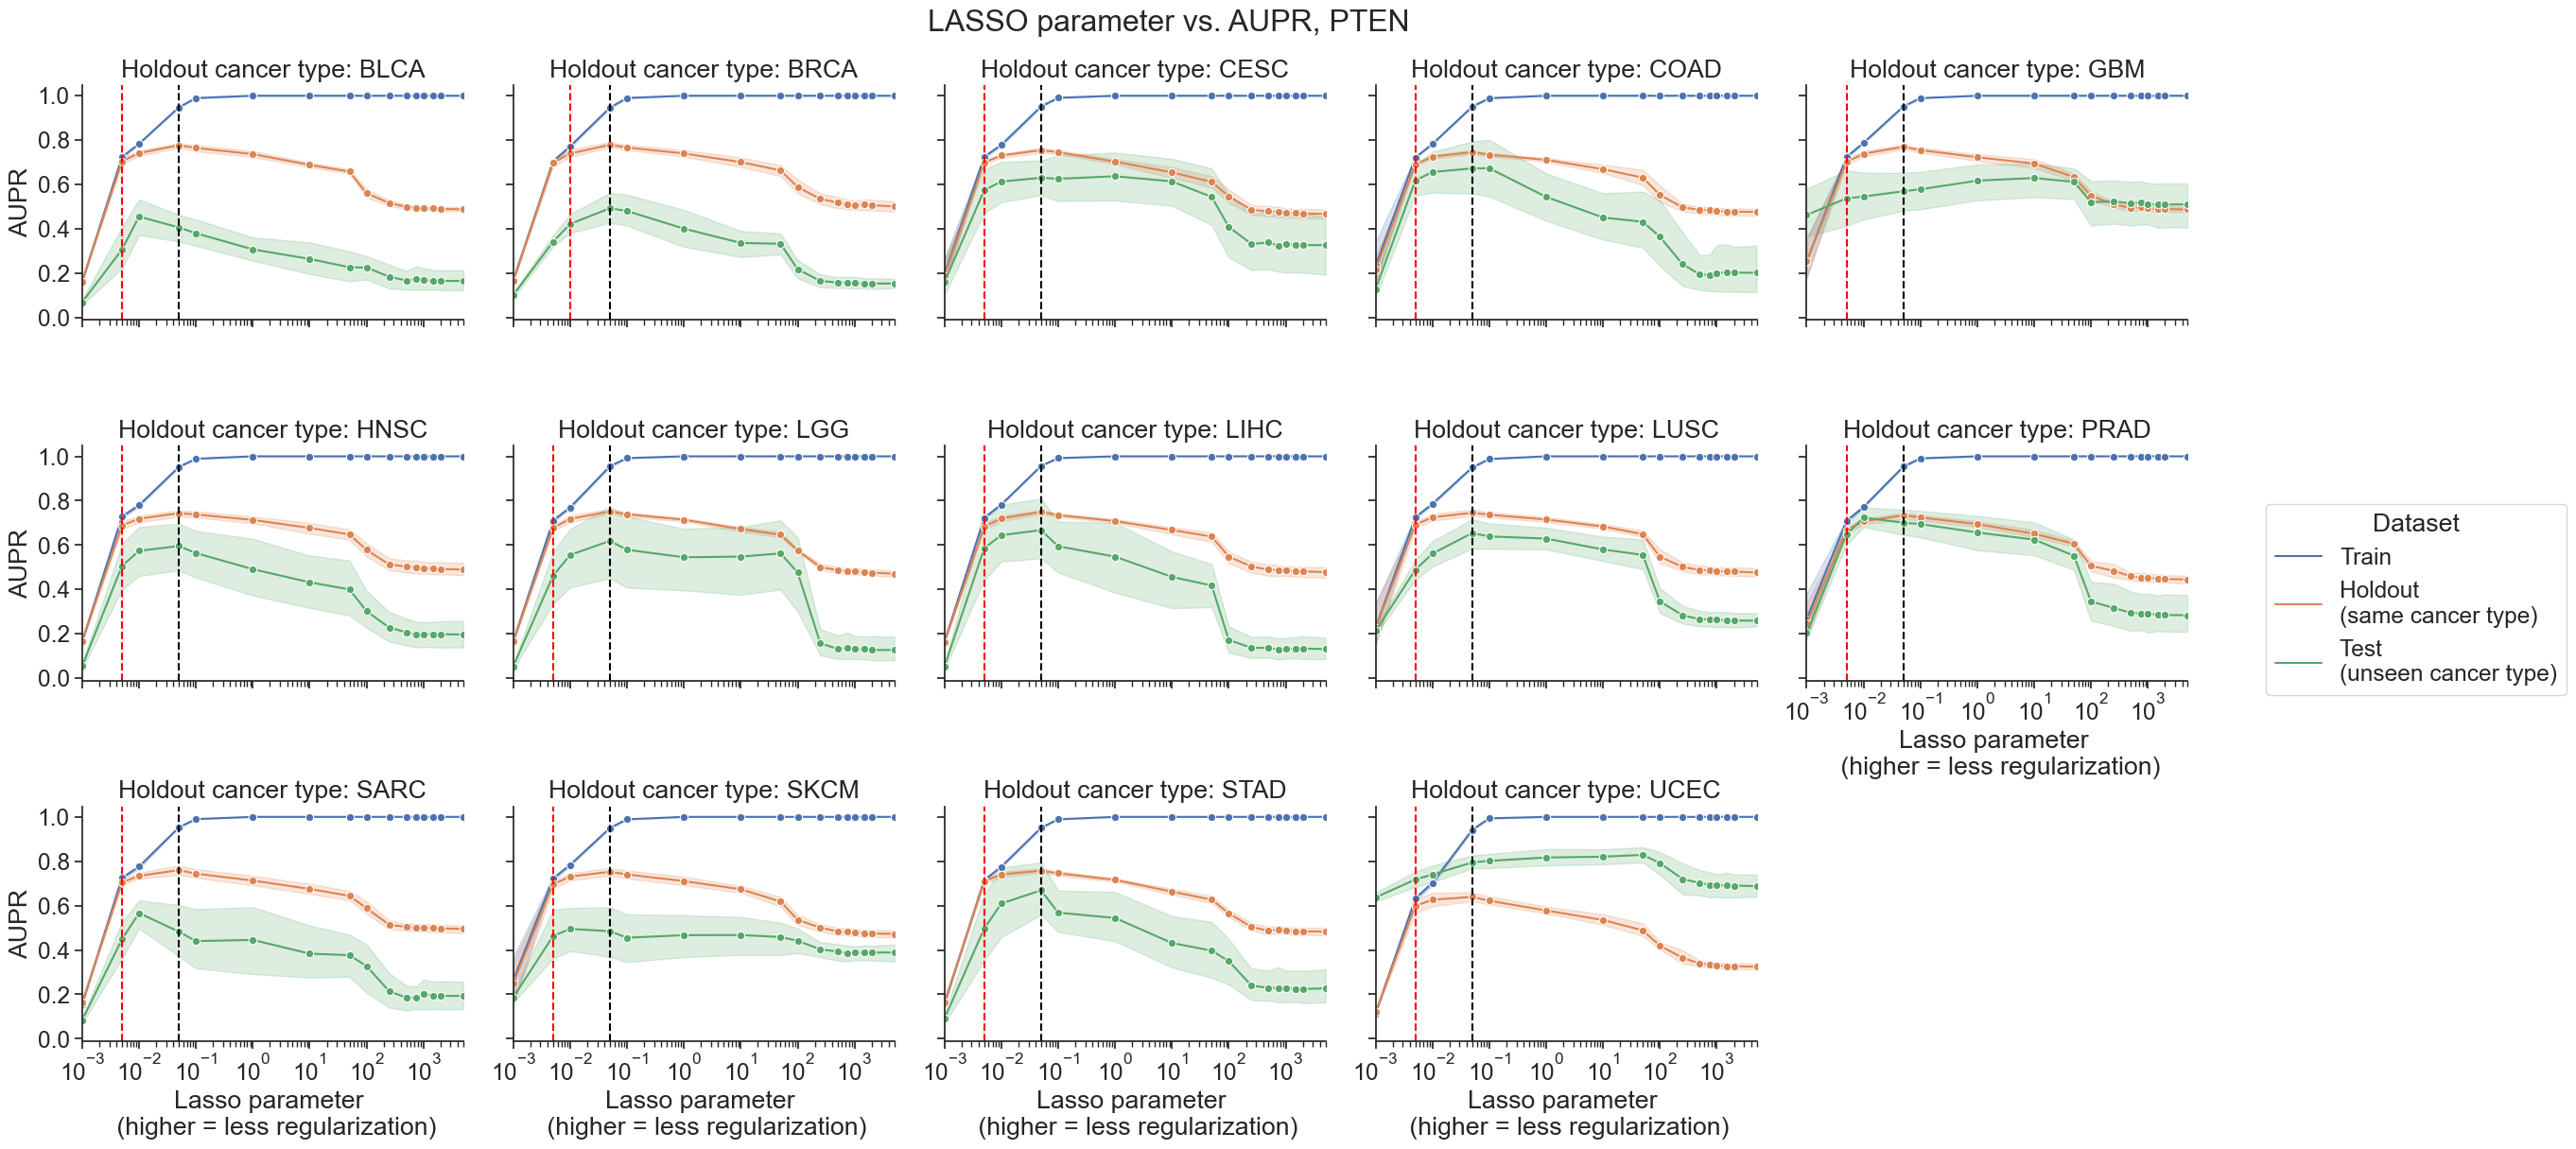

In [11]:
# same plot as before but with the "best"/"smallest" parameters marked
sns.set_style('ticks')

plot_df = (
    perf_df[(perf_df.signal == 'signal')]
      .sort_values(by=['holdout_cancer_type', 'lasso_param'])
      .reset_index(drop=True)
)
plot_df.lasso_param = plot_df.lasso_param.astype(float)

with sns.plotting_context('notebook', font_scale=1.6):
    g = sns.relplot(
        data=plot_df,
        x='lasso_param', y=metric, hue='data_type',
        hue_order=['train', 'cv', 'test'],
        marker='o',
        kind='line', col='holdout_cancer_type',
        col_wrap=5, height=4, aspect=1.2
    )
    g.set(xscale='log', xlim=(min(plot_df.lasso_param), max(plot_df.lasso_param)))
    g.set_xlabels('Lasso parameter \n (higher = less regularization)')
    g.set_ylabels(f'{metric.upper()}')
    sns.move_legend(g, "center", bbox_to_anchor=[1.02, 0.5], frameon=True)
    g._legend.set_title('Dataset')
    new_labels = ['Train', 'Holdout \n(same cancer type)', 'Test \n(unseen cancer type)']
    for t, l in zip(g._legend.texts, new_labels):
        t.set_text(l)
    
    def add_best_vline(data, **kws):
        ax = plt.gca()
        cancer_type = data.holdout_cancer_type.unique()[0]
        ax.axvline(x=compare_all_df[(compare_all_df.cancer_type == cancer_type) & (compare_all_df.desc == 'best')].index.values[0],
                   color='black', linestyle='--')
    def add_smallest_vline(data, **kws):
        ax = plt.gca()
        cancer_type = data.holdout_cancer_type.unique()[0]
        ax.axvline(x=compare_all_df[(compare_all_df.cancer_type == cancer_type) & (compare_all_df.desc == 'smallest')].index.values[0],
                   color='red', linestyle='--')
        
    g.map_dataframe(add_best_vline)
    g.map_dataframe(add_smallest_vline)
    g.set_titles('Holdout cancer type: {col_name}')
     
    plt.suptitle(f'LASSO parameter vs. {metric.upper()}, {plot_gene}', y=1.02)